# Постановка задачи

Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить. Вам поставлена задача создать такую модель.

## Признаки в исходном датасете

- hotel_address - адрес отеля
- review_date - дата, когда рецензент разместил соответствующий отзыв.
- average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
- hotel_name - название отеля
- reviewer_nationality - национальность рецензента
- negative_review - отрицательный отзыв, который рецензент дал отелю.
- review_total_negative_word_counts - общее количество слов в отрицательном отзыв
- positive_review - положительный отзыв, который рецензент дал отелю
- review_total_positive_word_counts - общее количество слов в положительном отзыве
- reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
- total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
- total_number_of_reviews - общее количество действительных отзывов об отеле
- tags - теги, которые рецензент дал отелю.
- days_since_review - продолжительность между датой проверки и датой очистки
- additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat - широта отеля
- lng - долгота отеля

In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date
import re

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
analyz = SentimentIntensityAnalyzer()

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем тесты для отбра признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [86]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [87]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [88]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# 1. Исследование данных

In [89]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [90]:
df_train.head(2)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

In [91]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [92]:
df_test.head(2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443

In [93]:
sample_submission.head(2)

reviewer_score      id
0               1  488440
1              10  274649

In [94]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [95]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [96]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [97]:
# ищем в столбцах данные, содержащие пропущенные значения
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

In [98]:
#построим график для визуальной оценки распределения оценок отелей
fig1_data = df_train['reviewer_score']
fig01 = px.box(
    fig1_data,
    x='reviewer_score',
    #color='Exited',
    height=400, width=1000,
    title='Распределение оценок'
    )
fig01.show()

fig02 = px.histogram(
    df_train,
    x='reviewer_score',
    histfunc='count',
    nbins=17,
    range_x=[0,10],
    height=400, width=1000,
    title='Распределение оценок'
    )
fig02.show()

# 2. Проектирование признаков (Feature Engineering)¶

## 2.1 Географическое расположение (review_date)

#### Выделим название города и страны из адреса

In [99]:
# создадим новый признак страны отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x:'United Kingdom' if x == 'Kingdom' else x)
country_list = list(hotels['hotel_country'].unique()) 
print(f'Количество стран, представленных в таблице: {len(country_list)}')
print(country_list)

Количество стран, представленных в таблице: 6
['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria']


In [100]:
# создадим новый признак города отеля
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
city_list = list(hotels['hotel_city'].unique())
print(f'Количество городов, представленных в таблице: {len(country_list)}')
print(city_list)

Количество городов, представленных в таблице: 6
['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']


In [101]:
# создадим дополнительную колонку-индикатор, находится ли отель в столице
capitals_list = ['Amsterdam', 'London', 'Paris', 'Vienna']
hotels['is_capital'] = hotels['hotel_city'].apply(lambda x: 1 if x in capitals_list else 0)

In [102]:
#кодировка города отеля методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['hotel_city'])
hotels = pd.concat([hotels, type_bin], axis=1)

## 2.2 Анализ дат (review_date)

In [103]:
# Разберем дату на признаки
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['month'] = hotels['review_date'].dt.month
hotels['dayofweek'] = hotels['review_date'].dt.dayofweek

# добавим признак выходного дня
hotels['is_weekend'] = hotels['dayofweek'].apply(lambda x: 1 if x > 5 else 0)
hotels['is_weekend'] = hotels['is_weekend'].astype('int')

# создаём и используем функцию для извлечения Рождества (потому что почему бы и нет!)
def get_christmas(date):
    if date.month == 12 & date.day == 25:
        return 1
    else:
        return 0
hotels['is_christmas'] = hotels['review_date'].apply(get_christmas)

# извлчечем количество дней из признака 'days_since_review' 
hotels['days_since_review'] = hotels['days_since_review'].str.split().str[0]
hotels['days_since_review'] = hotels['days_since_review'].astype('int') # переведем тип данных в int

# удаляем колонку типа datetime
hotels.drop(['review_date'], inplace=True, axis=1)

## 2.2 Анализ признака 'reviewer_nationality'

### Визуализируем распределение признака 

In [104]:
#данные для построения графика
bar_data = hotels.groupby('reviewer_nationality',as_index=False
)[['sample']].count().nlargest(15, columns=['sample'])
bar_data.rename(columns={'sample':'reviewer_number'},inplace=True)
bar_data

#строим график распределения рецензентов по странам
fig = px.bar(
    data_frame=bar_data, 
    x="reviewer_nationality", 
    y="reviewer_number", 
    color='reviewer_nationality', 
    text = 'reviewer_number', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='Распределение национальности рецензентов' 
)

#отображаем его
fig.show()

In [105]:
# очистим значения от лишних пробелов
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())

# отмечаем является ли рецензент гражданином страны, в которой находится отель
hotels['is_citizen'] = (hotels['reviewer_nationality'] == hotels['hotel_country']).astype(int)


# оставим в списке только 19 самых популярных национальностей, остальные заполним значением 'other'
top_nationality = hotels['reviewer_nationality'].value_counts().nlargest(19).index
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in top_nationality else 'other')

#кодируем признак национальности рецензента методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

## 2.3 Географическое расположение (широта и долгота)

In [106]:
# делаем копию датафрейма для обхода конфликта манипуляций с данными
hotels_coords = hotels.copy()

# формируем объект SeriesGroupBy
city_data = hotels_coords.groupby(['hotel_city'], group_keys=False)

# находим медианные координаты с учетом образовавшихся групп
city_data['lat'].median()
city_data['lng'].median()

# применяем lambda-функцию к SeriesGroupBy, заполняем пропуски соответствующим медианным значением
hotels_coords['lat'] = city_data['lat'].apply(lambda x: x.fillna(x.median()))
hotels_coords['lng'] = city_data['lng'].apply(lambda x: x.fillna(x.median()))

# переносим результат в исходный датафрейм
hotels = hotels_coords

# перепроверяем данные на пропуски
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
is_capital                                    0
hotel_city_1                            

## 2.4 Анализ тегов

In [107]:
# выясним количество ночей, проведенных в отеле
hotels['tags'] = hotels['tags'].apply(lambda x: x.lower())

#воспользуемся функцией для извлечения проведенного в отеле времени
def get_stayed_nights(tags):
    tags_list = tags.split(' ')
    if 'stayed' in tags_list:
        night_index = tags_list.index('stayed') + 1
        return int(tags_list[night_index])
    else:
        return np.NaN

hotels['stayed_nights'] = hotels['tags'].apply(get_stayed_nights)

# выведем количество пропущенных значений в признаке
print(hotels['stayed_nights'].isnull().sum())
print(hotels['stayed_nights'].mode()) # выясним модальное значение 
# возьмём на себя смелость заменить пропущенные значения модой 
hotels['stayed_nights'] = hotels['stayed_nights'].fillna(1)
# перепроверим данные на пропуски
print(hotels['stayed_nights'].isnull().sum())

192
0    1.0
dtype: float64
0


## 2.5 Работа с отзывами

### Попытаемся извлечь из отзывов дополнительные признаки, воспользовавшись библиотекой для обработки текстовой речи

In [108]:
# проводим анализ текста с помощью SentimentIntensityAnalyzer()
hotels['review_neg'] = hotels['negative_review'].apply(lambda x: analyz.polarity_scores(x))
hotels['review_pos'] = hotels['positive_review'].apply(lambda x: analyz.polarity_scores(x))

# результаты вносим в таблицу
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['review_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['review_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

In [109]:
hotels.head(3)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   

   additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci       United Kingdom   
1                           Urban Lodge Hotel              Belgium   
2  Alexandra Barcelona A DoubleTree by Hilton                other   

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  ...  \
0                                 62  ...   
1                                  0  ...   
2                                  5  ...   

                                          review_neg  \
0  {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...   
1  {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

                                          review_pos  n_neg  n_neu  n_pos  \
0  {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...  0.129  0.747  0.125   
1  {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...  0.216  0.784  0.000   
2  {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...  0.000  1.000  0.000   

   n_compound  p_neg  p_neu  p_pos  p_compound  
0     -0.0554  0.000  0.671  0.329      0.9615  
1     -0.2960  0.379  0.000  0.621      0.3400  
2      0.0000  0.000  0.260  0.740      0.6908  

[3 rows x 47 columns]

In [110]:
# очистим таблицу от признаков типа object
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

<AxesSubplot:>

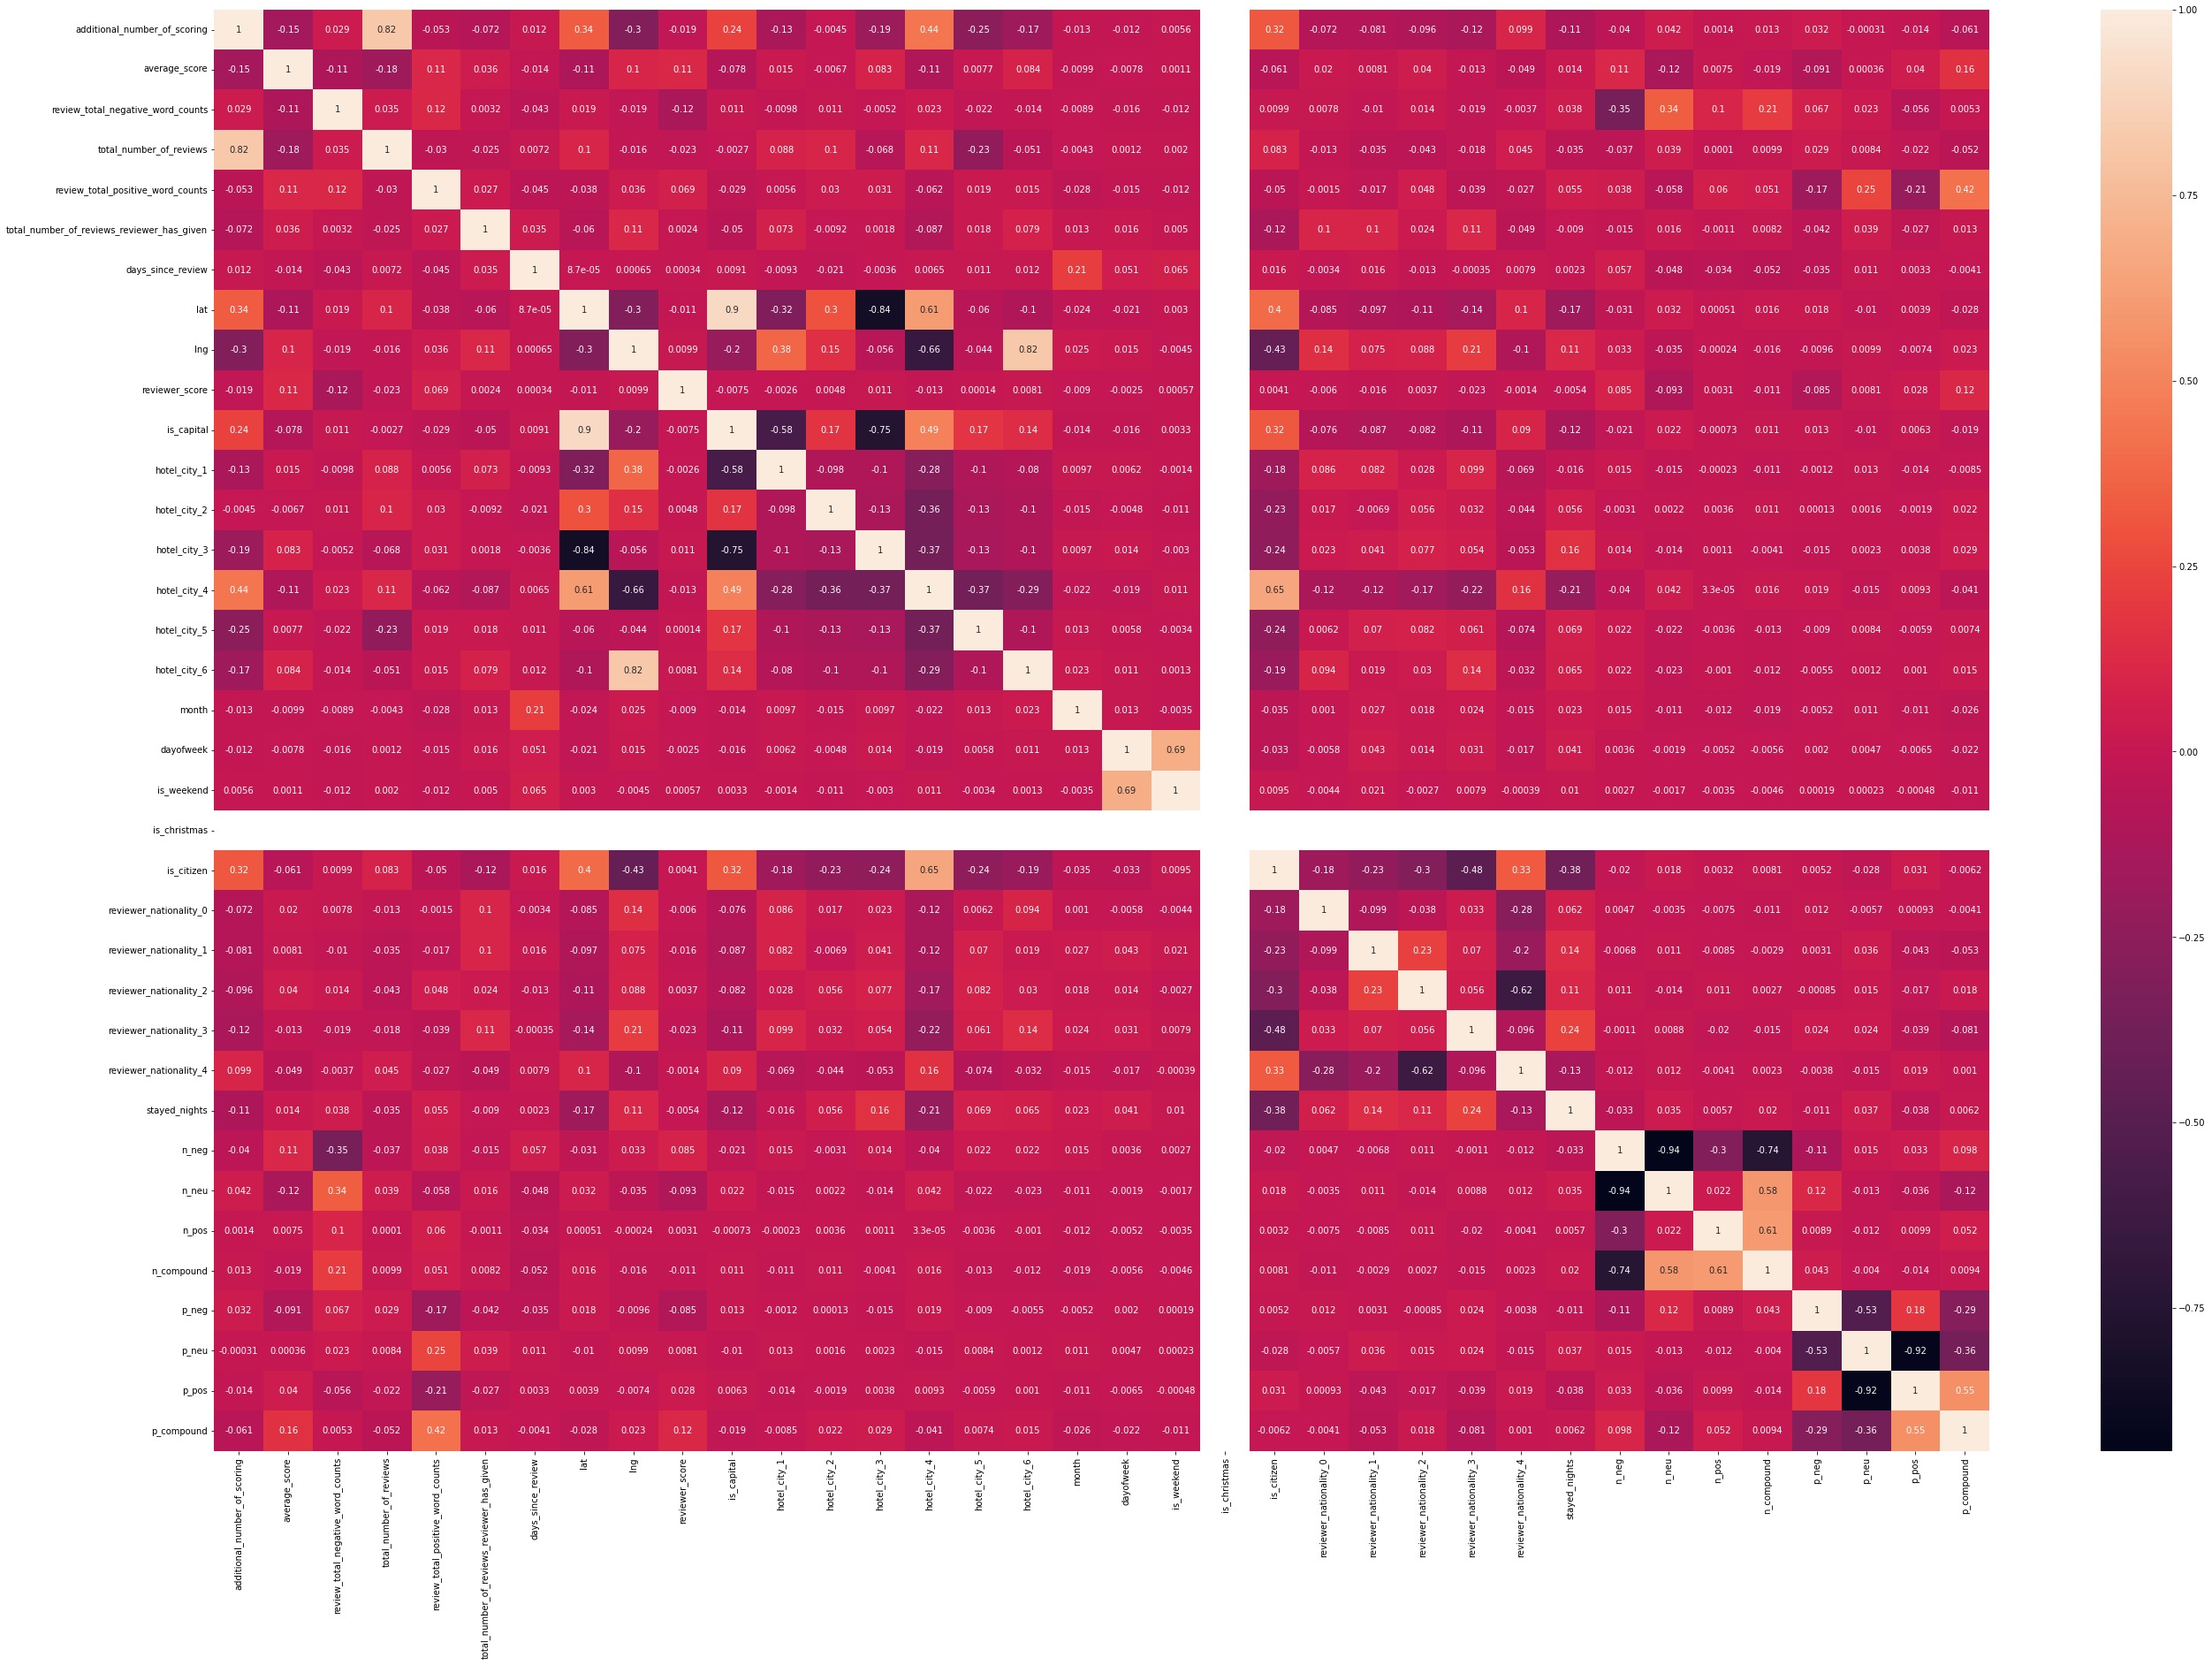

In [111]:
# строим матрицу корреляции для выявления мультиколлинеарных признаков
plt.rcParams['figure.figsize'] = (45,30)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

In [112]:
# удаляем мультиколлинеарные признаков
hotels.drop(['additional_number_of_scoring', 'n_neg', 'n_neu', 'p_neu', 'is_capital', 'hotel_city_3'], axis = 1, inplace=True) 

<AxesSubplot:>

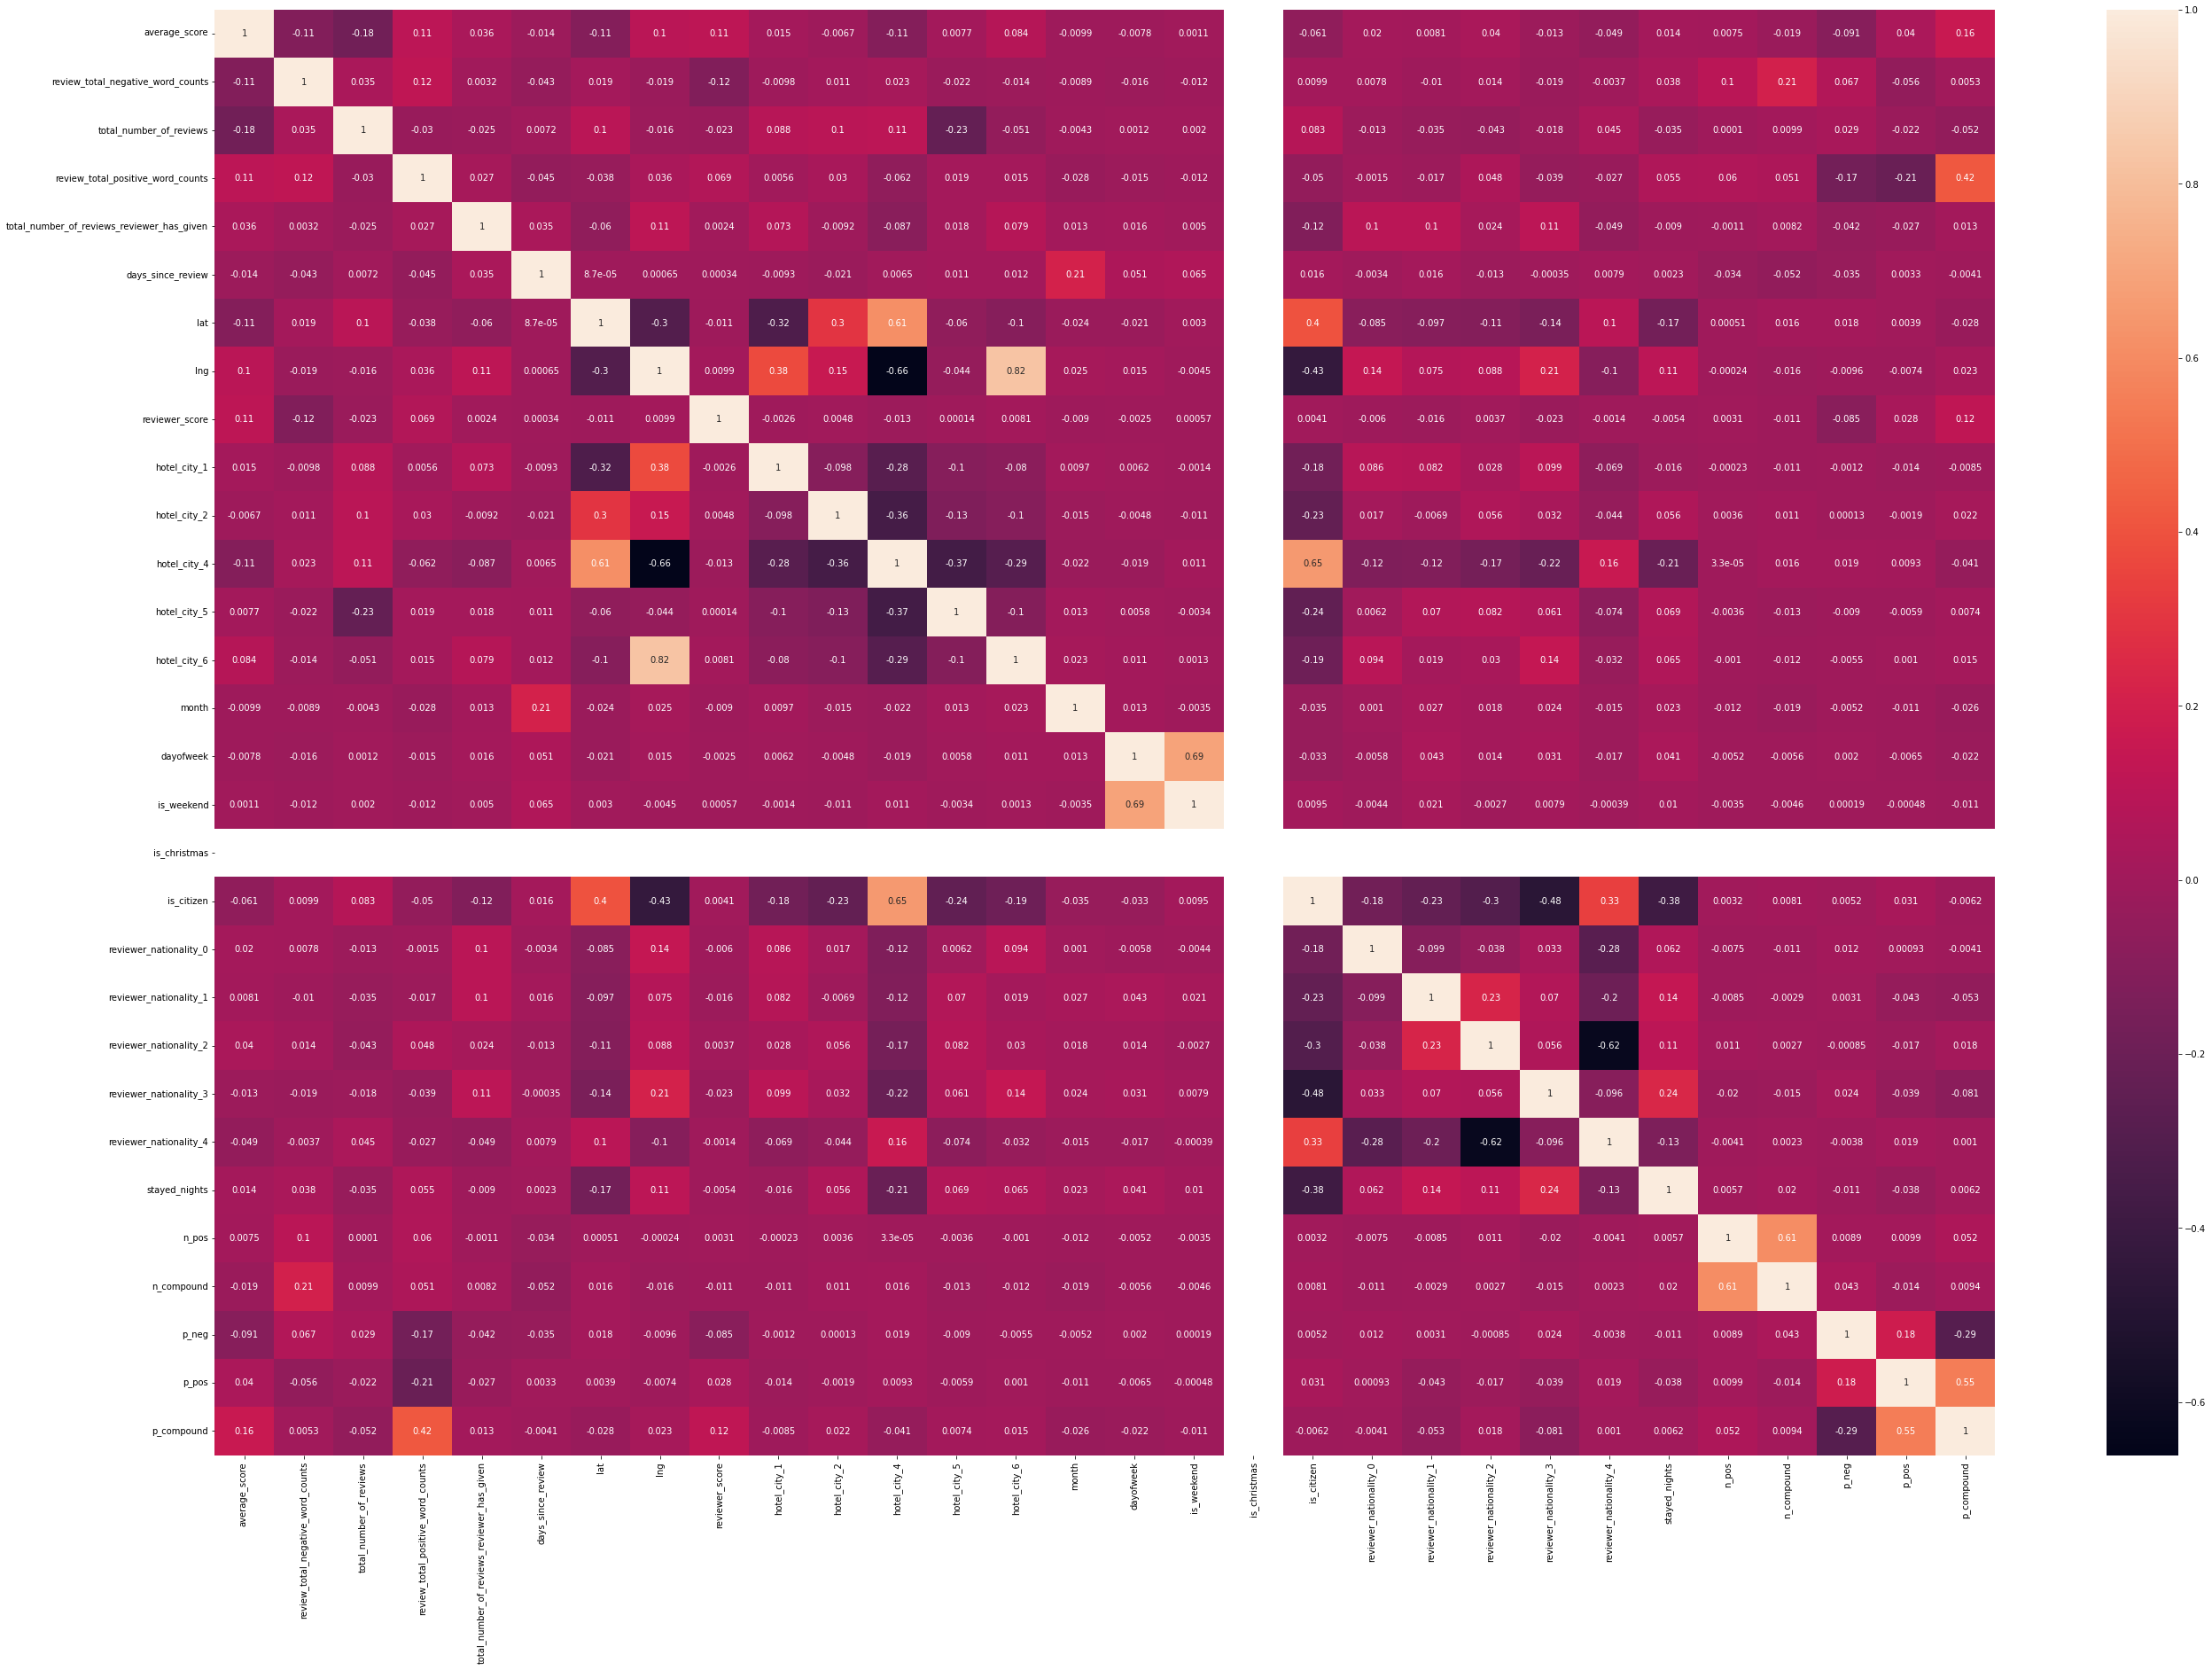

In [113]:
plt.rcParams['figure.figsize'] = (45,30)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

In [114]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

# 3. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ

In [115]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [116]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [117]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 30), (386803, 30), (386803, 29), (309442, 29), (77361, 29))

In [118]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [119]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [120]:
# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга отелей в тестовой выборке
# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [121]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8816373487071432


<AxesSubplot:>

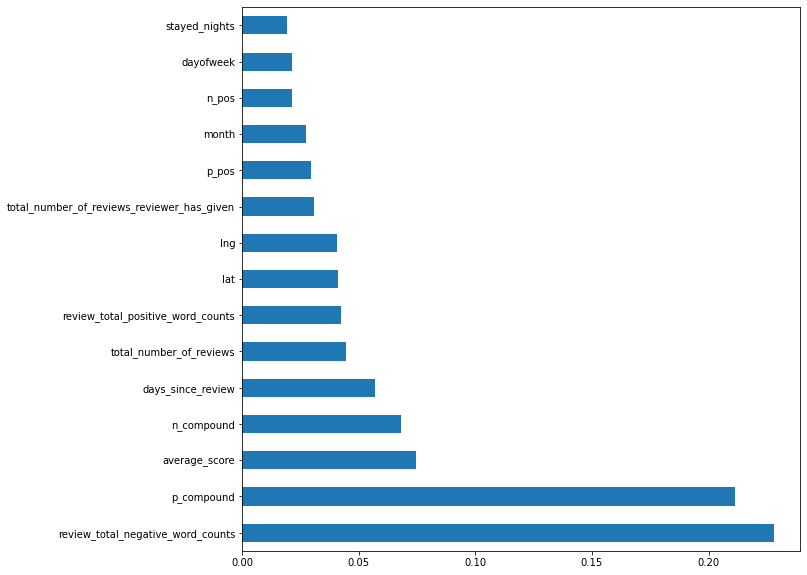

In [122]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [123]:
test_data.sample(10)

average_score  review_total_negative_word_counts  \
50974             8.9                                  3   
123820            8.7                                  5   
120295            9.4                                  0   
67768             8.2                                  8   
68833             8.2                                 22   
99536             8.2                                 16   
17150             8.3                                  0   
66578             8.4                                 53   
99435             8.6                                  2   
11296             8.9                                  3   

        total_number_of_reviews  review_total_positive_word_counts  \
50974                      2692                                  8   
123820                     2485                                 14   
120295                     2200                                  5   
67768                      2266                                  3   
68833                      2266                                  0   
99536                      3417                                 17   
17150                      3613                                 12   
66578                      4117                                 38   
99435                      2865                                  8   
11296                      1110                                 10   

        total_number_of_reviews_reviewer_has_given  days_since_review  \
50974                                            1                432   
123820                                           1                544   
120295                                           1                 73   
67768                                           27                 66   
68833                                            1                486   
99536                                            1                375   
17150                                            1                464   
66578                                            1                359   
99435                                            4                241   
11296                                            4                189   

              lat       lng  reviewer_score  hotel_city_1  ...  \
50974   51.516099 -0.118175             0.0             0  ...   
123820  51.493873 -0.182496             0.0             0  ...   
120295  51.504497 -0.085556             0.0             0  ...   
67768   51.522247 -0.142613             0.0             0  ...   
68833   51.522247 -0.142613             0.0             0  ...   
99536   52.369755  4.888782             0.0             0  ...   
17150   45.516167  9.227278             0.0             1  ...   
66578   51.513930 -0.101126             0.0             0  ...   
99435   52.376418  4.900220             0.0             0  ...   
11296   51.531427 -0.126133             0.0             0  ...   

        reviewer_nationality_1  reviewer_nationality_2  \
50974                        0                       0   
123820                       0                       0   
120295                       0                       0   
67768                        0                       0   
68833                        0                       0   
99536                        0                       0   
17150                        0                       0   
66578                        0                       0   
99435                        0                       0   
11296                        0                       0   

        reviewer_nationality_3  reviewer_nationality_4  stayed_nights  n_pos  \
50974                        0                       1            1.0  0.000   
123820                       0                       1            1.0  0.000   
120295                       0                       1            1.0  0.000   
67768                        0                       1            1.0  0.183   
68833 

In [124]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [125]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [126]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished


In [127]:
predict_submission

array([8.67 , 7.026, 8.704, ..., 8.388, 9.597, 7.443])

In [128]:
list(sample_submission)

['reviewer_score', 'id']

In [129]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.670  488440
1           7.026  274649
2           8.704  374688
3           9.744  404352
4           9.644  451596
5           9.079  302161
6           7.903  317079
7           7.310   13963
8           8.452  159785
9           7.391  195089